In [3]:
USE_CORRECTED = False

In [127]:
import matplotlib.pyplot as plt
from matplotlib import colormaps, colors
import csv
import operator as op
import math
import numpy as np
import scipy.stats as stats

class CsvReaderHeading:
    def __init__(self, file, **csvreader_kwargs):
        self.reader = csv.reader(file, **csvreader_kwargs)
        self.header = next(self.reader)
        self.indices = range(len(self.header))

    def __iter__(self):
        return self
        
    def __next__(self):
        as_list = next(self.reader)
        return { self.header[i]: as_list[i] for i in self.indices }

class CsvTable:
    def __init__(self, itr):
        self.itr = itr
    
    def populate(self):
        self.rows = list(self.itr)
        self.keys = self.rows[0].keys()
    
    @property
    def cols(self):
        return { k: [ int(row[k]) for row in self.rows ] for k in self.keys }
    
    @property
    def freqs(self):
        return {k: frequencies(self.cols[k]) for k in self.keys }

def frequencies(xs):
    result = {}
    for x in xs:
        if x not in result:
            result[x] = 0
        result[x] += 1
    return result

In [128]:
table = None
with open("log_corr.csv" if USE_CORRECTED else "diamond_orig.csv", "r") as f:
    reader = CsvReaderHeading(f)
    table = CsvTable(reader)
    table.populate()

In [129]:
savefig_kwargs = {
    "dpi": 450,
    "bbox_inches": "tight"
}

In [130]:
def plot_histogram(x, xlabel, title, lines=None, ax=plt, cmap=lambda _: "darkblue", log=False, name="unknown", alternative="greater"):
    ttest_result = stats.ttest_1samp(x, 0., alternative=alternative)
    print(ttest_result)
    freqs = frequencies(x)
    items = list(freqs.keys())
    items.sort()
    values = [ freqs[item] for item in items ]
    ax.bar(
        items, values,
        color=[
            cmap(((item / max(map(abs, items))) + 1) / 2)
            for item in items
        ],
        width=1.0,
    )
    if log:
        ax.yscale("log")
    #ax.xlabel(xlabel)
    #ax.ylabel("Frequency")
    #ax.title(title)
    if lines == None:
        lines = []
    for (line, color) in lines:
        height = max(values)
        start = min(items)
        ax.axline([line, 0], [line, height], color=color, linewidth=3, linestyle="solid")
    if ax is plt:
        plt.savefig(f"diffhist-{name}.png", **savefig_kwargs)
        plt.show()
        
def plot_diffhist(table, key1, key2, title, **kwargs):
    def mod(v):
        return v * 0.75
    def cmap(t):
        (r, g, b, a) = colormaps["seismic_r"](t)
        return (mod(r), mod(g), mod(b), a)
    data = map(op.sub, table.cols[key1], table.cols[key2])
    data = list(data)
    plot_histogram(
        data,
        f"{key1} minus {key2}",
        f"{title}: {key1} vs {key2}",
        lines=[(0, "black")],
        cmap=cmap,
        log=False,
        **kwargs,
    )

TtestResult(statistic=7.728217086860962, pvalue=3.0219788980863197e-14, df=499)


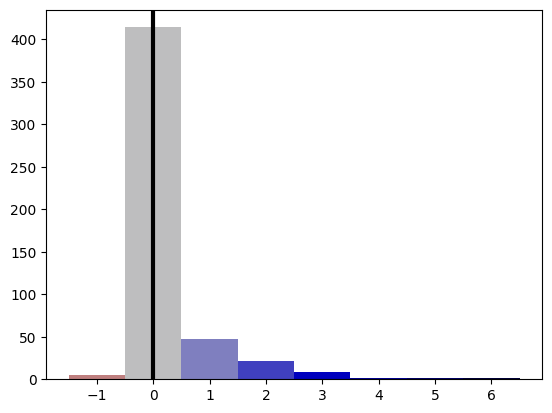

TtestResult(statistic=11.730908152261163, pvalue=1.5491840682133743e-28, df=499)


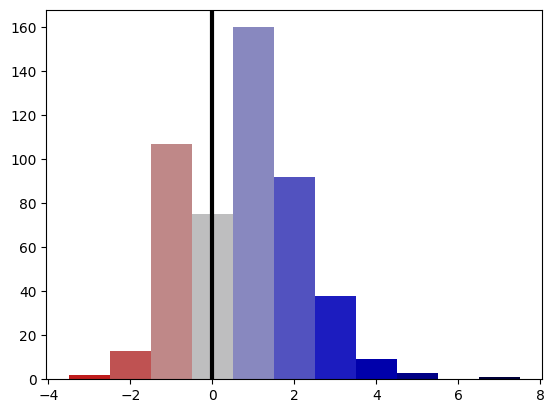

TtestResult(statistic=6.770205767883652, pvalue=1.8114710732660727e-11, df=499)


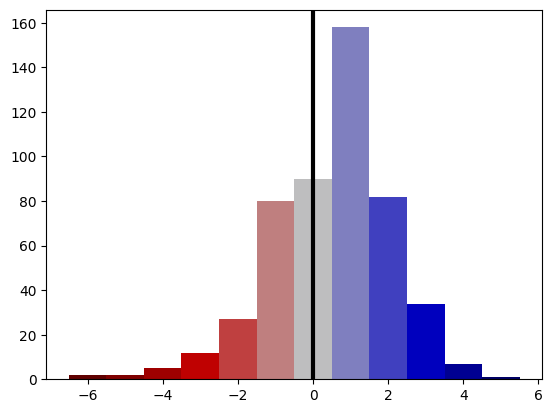

In [131]:
difftitle = "Differences in Counts"
plot_diffhist(table, "SiMReQ (Simple)", "DSE", difftitle, name="simplevdse")
plot_diffhist(table, "SiMReQ (JIT DSE)", "DSE", difftitle, name="jitdsevdse")
plot_diffhist(table, "SiMReQ (JIT DSE)", "SiMReQ (Simple)", difftitle, name="simplevjitdse")

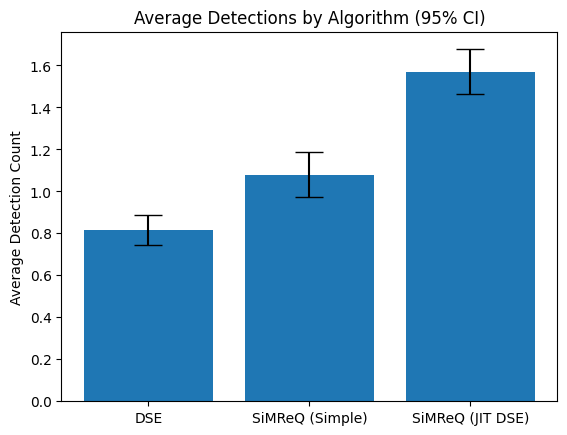

[0.816, 1.08, 1.57]


In [132]:
columns = table.cols.items()
n = len(table.rows)
items = ["DSE", "SiMReQ (Simple)", "SiMReQ (JIT DSE)"]
error_bars = [ 1.96 * (np.std(v) / math.sqrt(n)) for (_, v) in columns ]
means = [ np.mean(v) for (_, v) in columns ]
plt.bar(items, means, yerr=error_bars, ecolor="black", capsize=10)
plt.ylabel("Average " + ("Relative " if USE_CORRECTED else "") + "Detection Count")
plt.title("Average Detections by Algorithm (95% CI)")
plt.savefig("avgdetbyalg.png", **savefig_kwargs)
plt.show()
print(means)

In [133]:
meandet_dse, meandet_simreq_simple, meandet_simreq_jitdse = (*means,)
def percent_increase(orig, modif):
    number = ((modif - orig) / orig) * 100
    return f"{number:.2f}%"
print(f"DSE -> SiMReQ (Simple):")
print(percent_increase(meandet_dse, meandet_simreq_simple))
print(f"DSE -> SiMReQ (JIT DSE):")
print(percent_increase(meandet_dse, meandet_simreq_jitdse))
print(f"SiMReQ... (JIT DSE -> Simple):")
print(percent_increase(meandet_simreq_simple, meandet_simreq_jitdse))

DSE -> SiMReQ (Simple):
32.35%
DSE -> SiMReQ (JIT DSE):
92.40%
SiMReQ... (JIT DSE -> Simple):
45.37%


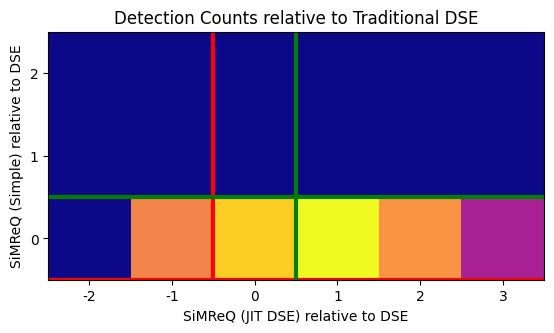

In [11]:
"""
# NO LONGER USING THESE HEATMAPS
col_dse, col_simreq_simple, col_simreq_jitdse = table.cols["DSE"], table.cols["SiMReQ (Simple)"], table.cols["SiMReQ (JIT DSE)"]
paired_rel = [
    (col_simreq_jitdse[i] - col_dse[i], col_simreq_simple[i] - col_dse[i])
    for i in range(len(table.rows))
]
prel_zip = list(zip(*paired_rel))
xhi, xlo, yhi, ylo = max(prel_zip[0]), min(prel_zip[0]), max(prel_zip[1]), min(prel_zip[1])
plt.axes().set_aspect("equal")
plt.hist2d(*prel_zip, bins=(xhi - xlo, yhi - ylo), cmap="plasma", norm=colors.LogNorm(clip=True))
plt.axline([0, 0], [0, 1], color="red", linewidth=3)
plt.axline([0, 0], [1, 0], color="red", linewidth=3)
plt.axline([0, 1], [1, 1], color="green", linewidth=3)
plt.axline([1, 0], [1, 1], color="green", linewidth=3)
plt.xticks(np.arange(xlo+.5, xhi+.5, 1), np.arange(xlo, xhi, 1))
plt.yticks(np.arange(ylo+.5, yhi+.5, 1), np.arange(ylo, yhi, 1))
plt.xlabel("SiMReQ (JIT DSE) relative to DSE")
plt.ylabel("SiMReQ (Simple) relative to DSE")
plt.title("Detection Counts relative to Traditional DSE")
plt.savefig("hist2d-rel.png", **savefig_kwargs)
plt.show()
"""

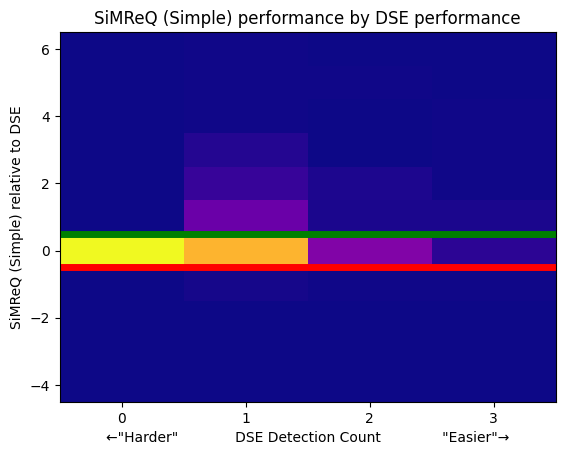

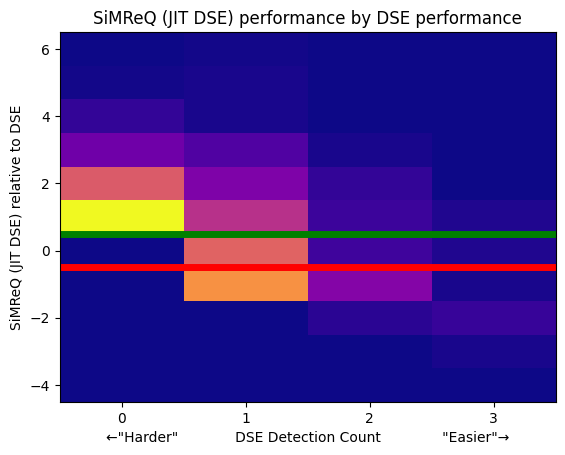

In [135]:
def plot_heatmap_diff_over_trad(what, name="unknown"):
    rangex = [ i - 0.5 for i in (0, 4) ]
    rangey = [ i - 0.5 for i in (-4, 7) ]
    plt.hist2d(
        [ i - 0.5 for i in table.cols["DSE"] ],
        list(map(lambda x, y: (x - y) - 0.5, table.cols[what], table.cols["DSE"])),
        cmap="plasma",
        range=(rangex, rangey),
        bins=(int(rangex[1]-rangex[0]), int(rangey[1]-rangey[0])),
    )
    plt.xticks([0.0, 1.0, 2.0, 3.0])
    plt.axline([0, -0.5], [1, -0.5], color="red", linewidth=5)
    plt.axline([0, 0.5], [1, 0.5], color="green", linewidth=5)
    spaces = " " * 12
    offset = " " * 1
    plt.xlabel(f"←\"Harder\"{spaces} DSE Detection Count {offset}{spaces}\"Easier\"→")
    plt.ylabel(f"{what} relative to DSE")
    plt.title(f"{what} performance by DSE performance")
    plt.savefig(f"dsejd2d-{name}.png", **savefig_kwargs)
    plt.show()
plot_heatmap_diff_over_trad("SiMReQ (Simple)", "simple")
plot_heatmap_diff_over_trad("SiMReQ (JIT DSE)", "jitdse")